# Faster CNN Notebook

## DvXray Full Processing Pipeline  

### Imports & Config

In [1]:
import os
import json
import shutil
import random
import numpy as np
from tqdm import tqdm

# Base directories
BASE = "./data"
RAW_POS = f"{BASE}/raw/DvXray_Positive_Samples"
RAW_NEG = f"{BASE}/raw/DvXray_Negative_Samples"

SPLIT_DIR = f"{BASE}/split"
YOLO_OUT = f"{BASE}/processed/yolo"
COCO_OUT = f"{BASE}/processed/coco"
CLS_OUT  = f"{BASE}/processed/classification"

IMG_W = 800
IMG_H = 600
TRAIN_RATIO = 0.8

random.seed(19)

prohibited_item_classes = {
    'Gun': 0, 'Knife': 1, 'Wrench': 2, 'Pliers': 3, 'Scissors': 4,
    'Lighter': 5, 'Battery': 6, 'Bat': 7, 'Razor_blade': 8,
    'Saw_blade': 9, 'Fireworks': 10, 'Hammer': 11,
    'Screwdriver': 12, 'Dart': 13, 'Pressure_vessel': 14
}

print("Config loaded.")


Config loaded.


In [2]:
import zipfile
import os

RAW_DIR = "./data/raw"
ZIP_POS = "./data/raw/DvXray_Positive_Samples.zip"
ZIP_NEG = "./data/raw/DvXray_Negative_Samples.zip"
OUT_POS = "./data/raw/DvXray_Positive_Samples"
OUT_NEG = "./data/raw/DvXray_Negative_Samples"

os.makedirs(RAW_DIR, exist_ok=True)

def unzip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(RAW_DIR)
        print("Done.\n")
    else:
        print(f"Already extracted: {extract_to}")

unzip(ZIP_POS, OUT_POS)
unzip(ZIP_NEG, OUT_NEG)

print("Positive folder exists:", os.path.exists(OUT_POS))
print("Negative folder exists:", os.path.exists(OUT_NEG))


Already extracted: ./data/raw/DvXray_Positive_Samples
Already extracted: ./data/raw/DvXray_Negative_Samples
Positive folder exists: True
Negative folder exists: True


### Utility: Normalize BBox

In [3]:
def normalize_bbox(bb, json_path, view_name):
    """Normalize bbox into [x1,y1,x2,y2] or return None."""

    if bb is None or bb == "difficult":
        return None
    if bb == []:
        return None
    if isinstance(bb, list) and len(bb) == 1 and isinstance(bb[0], list):
        bb = bb[0]
    if len(bb) > 4:
        print(f"[WARN] {json_path}: {view_name} has {len(bb)} values → truncating.")
        bb = bb[:4]
    if len(bb) != 4:
        print(f"[WARN] {json_path}: {view_name} INVALID ({bb}) → skipping.")
        return None
    return bb


### Utility: Classification Label Vector

In [4]:
def get_label_vector(json_path):
    """Return multi-hot 15-dim vector."""
    data = json.load(open(json_path))
    objs = data["objects"]

    if objs == "None":
        return np.zeros(15, dtype=np.int32)

    arr = np.zeros(15, dtype=np.int32)
    for obj in objs:
        idx = prohibited_item_classes[obj["label"]]
        arr[idx] = 1
    return arr


### Step 1: Create Train/Val Split

In [5]:
os.makedirs(SPLIT_DIR, exist_ok=True)

all_ids = []
for folder in [RAW_POS, RAW_NEG]:
    for f in os.listdir(folder):
        if f.endswith(".json"):
            all_ids.append(f.replace(".json", ""))

all_ids.sort()
n = len(all_ids)
k = int(n * TRAIN_RATIO)
train_ids = set(random.sample(all_ids, k))

with open(f"{SPLIT_DIR}/train.txt", "w") as f:
    for sid in all_ids:
        if sid in train_ids:
            f.write(sid + "\n")

with open(f"{SPLIT_DIR}/val.txt", "w") as f:
    for sid in all_ids:
        if sid not in train_ids:
            f.write(sid + "\n")

print(f"Split complete. Total: {n}, Train: {k}, Val: {n-k}")


Split complete. Total: 16000, Train: 12800, Val: 3200


### Step 3: COCO Conversion

In [6]:
for split in ["train", "val"]:
    os.makedirs(f"{COCO_OUT}/{split}", exist_ok=True)
os.makedirs(f"{COCO_OUT}/annotations", exist_ok=True)

def coco_generate(split_name):

    img_id = 1
    ann_id = 1

    images = []
    annotations = []

    ids = open(f"{SPLIT_DIR}/{split_name}.txt").read().split()
    out_img_dir = f"{COCO_OUT}/{split_name}"

    for sid in tqdm(ids):
        folder = RAW_POS if os.path.exists(f"{RAW_POS}/{sid}.json") else RAW_NEG
        json_path = f"{folder}/{sid}.json"
        data = json.load(open(json_path))
        objs = data["objects"]

        for view in ["OL", "SD"]:

            fname = f"{sid}_{view}.png"
            shutil.copy(f"{folder}/{fname}", out_img_dir)

            images.append({
                "id": img_id,
                "file_name": fname,
                "width": IMG_W,
                "height": IMG_H
            })

            if objs != "None":
                for obj in objs:
                    cls = prohibited_item_classes[obj["label"]]
                    bb = obj["ol_bb"] if view == "OL" else obj["sd_bb"]
                    bb = normalize_bbox(bb, json_path, view)
                    if bb is None:
                        continue
                    x1, y1, x2, y2 = bb
                    w = x2 - x1
                    h = y2 - y1

                    annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": cls,
                        "bbox": [x1, y1, w, h],
                        "area": w * h,
                        "iscrowd": 0
                    })
                    ann_id += 1

            img_id += 1

    coco_dict = {
        "images": images,
        "annotations": annotations,
        "categories": [
            {"id": cid, "name": name}
            for name, cid in prohibited_item_classes.items()
        ]
    }

    with open(f"{COCO_OUT}/annotations/instances_{split_name}.json", "w") as f:
        json.dump(coco_dict, f, indent=4)

    print(f"COCO {split_name} done: {len(images)} images, {len(annotations)} annotations.")


### Run COCO

In [7]:
coco_generate("train")
coco_generate("val")
print("COCO dataset complete.")


100%|███████████████████████████████████████████████████████████████████████████| 12800/12800 [00:33<00:00, 380.06it/s]


COCO train done: 25600 images, 8406 annotations.


100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:08<00:00, 371.11it/s]


COCO val done: 6400 images, 2177 annotations.
COCO dataset complete.


### Step 4: Classification Dataset

In [8]:
for split in ["train", "val"]:
    os.makedirs(f"{CLS_OUT}/{split}", exist_ok=True)

for split in ["train", "val"]:
    ids = open(f"{SPLIT_DIR}/{split}.txt").read().split()
    out_dir = f"{CLS_OUT}/{split}"

    for sid in tqdm(ids):
        folder = RAW_POS if os.path.exists(f"{RAW_POS}/{sid}.json") else RAW_NEG
        json_path = f"{folder}/{sid}.json"

        lbl = get_label_vector(json_path)
        np.save(f"{out_dir}/{sid}.npy", lbl)

        shutil.copy(f"{folder}/{sid}_OL.png", out_dir)
        shutil.copy(f"{folder}/{sid}_SD.png", out_dir)

print("Classification dataset complete.")


100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:09<00:00, 324.92it/s]

Classification dataset complete.


## Pipeline Completed Successfully!

### ✔ COCO dataset  
- data/processed/coco/train  
- instances_train.json  

### ✔ Classification dataset  
- data/processed/classification/train  
- .npy multi-label files  

We use COCO format because Faster CNN algorithm uses absolute bounding boxes and a labeling structure that includes a fully annotated dictionary.

## Faster CNN

Because we are using Torchvision, this requires images to be resized to tensors, bounding boxes must be created using four points (corners), and labels.

In [9]:
import json

TRAIN_JSON = "./data/processed/coco/annotations/instances_train.json"

with open(TRAIN_JSON, "r") as f:
    coco_data = json.load(f)

# Count annotations per image
ann_count = {img["id"]: 0 for img in coco_data["images"]}
for ann in coco_data["annotations"]:
    ann_count[ann["image_id"]] += 1

# Keep only images with annotations
valid_image_ids = {img_id for img_id, count in ann_count.items() if count > 0}

print("Total images:", len(coco_data["images"]))
print("Images with at least 1 object:", len(valid_image_ids))
print("Empty images removed:", len(coco_data["images"]) - len(valid_image_ids))


Total images: 25600
Images with at least 1 object: 7649
Empty images removed: 17951


In [10]:
# Build Dataset Class for Faster R-CNN format
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F

class XRayDataset(CocoDetection):
    def __init__(self, root, annFile, valid_ids=None):
        super().__init__(root=root, annFile=annFile)
        self.valid_ids = valid_ids
        if valid_ids is not None:
            self.ids = [i for i in self.ids if i in valid_ids]  # filter ids

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        boxes = []
        labels = []

        for a in anns:
            x, y, w, h = a["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(a["category_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return F.to_tensor(img), target

In [11]:
# Load COCO datasets
from torch.utils.data import DataLoader

COCO_DIR = "./data/processed/coco"

train_dataset = XRayDataset(
    root=f"{COCO_DIR}/train",
    annFile=f"{COCO_DIR}/annotations/instances_train.json",
    valid_ids=valid_image_ids  # ONLY annotated images
)

val_dataset = XRayDataset(
    root=f"{COCO_DIR}/val",
    annFile=f"{COCO_DIR}/annotations/instances_val.json",
    valid_ids=None  # keep empty images for evaluation
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,   
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,   
    pin_memory=True,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 16  # background + 15 items

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace head with custom classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [13]:
# Train model
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {total_loss:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [20:45<00:00,  3.07it/s]


Epoch 1/50 - Training Loss: 675.2151


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:35<00:00,  3.25it/s]


Epoch 2/50 - Training Loss: 487.1471


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:32<00:00,  3.26it/s]


Epoch 3/50 - Training Loss: 409.3469


100%|████████████████████████████████████████████████████████████████████████████| 3825/3825 [7:41:44<00:00,  7.24s/it]


Epoch 4/50 - Training Loss: 353.1465


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [20:03<00:00,  3.18it/s]


Epoch 5/50 - Training Loss: 311.6814


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [20:44<00:00,  3.07it/s]


Epoch 6/50 - Training Loss: 287.0127


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [21:06<00:00,  3.02it/s]


Epoch 7/50 - Training Loss: 261.1632


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:52<00:00,  3.21it/s]


Epoch 8/50 - Training Loss: 240.3914


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:45<00:00,  3.23it/s]


Epoch 9/50 - Training Loss: 226.5952


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [20:54<00:00,  3.05it/s]


Epoch 10/50 - Training Loss: 206.2791


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [20:58<00:00,  3.04it/s]


Epoch 11/50 - Training Loss: 200.0576


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:49<00:00,  3.22it/s]


Epoch 12/50 - Training Loss: 196.6736


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:34<00:00,  3.26it/s]


Epoch 13/50 - Training Loss: 181.3811


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:31<00:00,  3.26it/s]


Epoch 14/50 - Training Loss: 174.9091


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:35<00:00,  3.25it/s]


Epoch 15/50 - Training Loss: 167.9399


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:35<00:00,  3.26it/s]


Epoch 16/50 - Training Loss: 159.8136


IOPub message rate exceeded.████████████████████████▏                              | 2315/3825 [11:50<07:39,  3.29it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.█████████████████████████████████████████▋             | 3173/3825 [16:16<03:19,  3.26it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:42<00:00,  3.24it/s]


Epoch 40/50 - Training Loss: 99.5269


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:43<00:00,  3.23it/s]


Epoch 41/50 - Training Loss: 94.7270


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:39<00:00,  3.24it/s]


Epoch 42/50 - Training Loss: 96.3033


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:37<00:00,  3.25it/s]


Epoch 43/50 - Training Loss: 100.5428


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:31<00:00,  3.27it/s]


Epoch 44/50 - Training Loss: 100.3290


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:38<00:00,  3.25it/s]


Epoch 45/50 - Training Loss: 92.2489


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:45<00:00,  3.23it/s]


Epoch 46/50 - Training Loss: 104.5137


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [20:18<00:00,  3.14it/s]


Epoch 47/50 - Training Loss: 97.1298


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:47<00:00,  3.22it/s]


Epoch 48/50 - Training Loss: 97.7854


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:34<00:00,  3.26it/s]


Epoch 49/50 - Training Loss: 95.1136


100%|██████████████████████████████████████████████████████████████████████████████| 3825/3825 [19:35<00:00,  3.25it/s]

Epoch 50/50 - Training Loss: 100.5252


In [14]:
# Save model weights
save_path = "fasterrcnn_dvxray_weights.pth"
torch.save(model.state_dict(), save_path)

print(f"Model weights saved to: {save_path}")

Model weights saved to: fasterrcnn_dvxray_weights.pth


### Run Inference on Sample Images

In [26]:
num_classes = 16  

model = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
model.load_state_dict(torch.load("fasterrcnn_dvxray_weights.pth", map_location='cpu'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on:", device)

C:\Users\orand\AppData\Local\Temp\ipykernel_13820\471806017.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fasterrcnn_dvxray_weights.p

Model loaded on: cuda


In [28]:
import os

neg_folder = "data/raw/DvXray_Negative_Samples"
pos_folder = "data/raw/DvXray_Positive_Samples"

# Collect negative images
neg_images = [os.path.join(neg_folder, f) for f in os.listdir(neg_folder)
              if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Collect positive images
pos_images = [os.path.join(pos_folder, f) for f in os.listdir(pos_folder)
              if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

print("Negative images:", len(neg_images))
print("Positive images:", len(pos_images))

print("\nSample negative:", neg_images[0])
print("Sample positive:", pos_images[0])


Negative images: 22000
Positive images: 10000

Sample negative: data/raw/DvXray_Negative_Samples\N00000_OL.png
Sample positive: data/raw/DvXray_Positive_Samples\P00000_OL.png


In [29]:
# Run Inference
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([T.ToTensor()])

def run_inference(img_path, model):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        outputs = model([img_tensor])
    
    return img, outputs[0]

In [30]:
# Visualize Bounding Boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(img, pred, threshold=0.5):
    boxes = pred['boxes'].cpu()
    scores = pred['scores'].cpu()
    labels = pred['labels'].cpu()

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    ax = plt.gca()

    for i, box in enumerate(boxes):
        if scores[i] < threshold:
            continue
        
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), (x2-x1), (y2-y1),
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        ax.text(x1, y1-5, f"{labels[i].item()} | {scores[i]:.2f}",
                color='yellow', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

Scores for NEGATIVE image: tensor([0.0557], device='cuda:0')


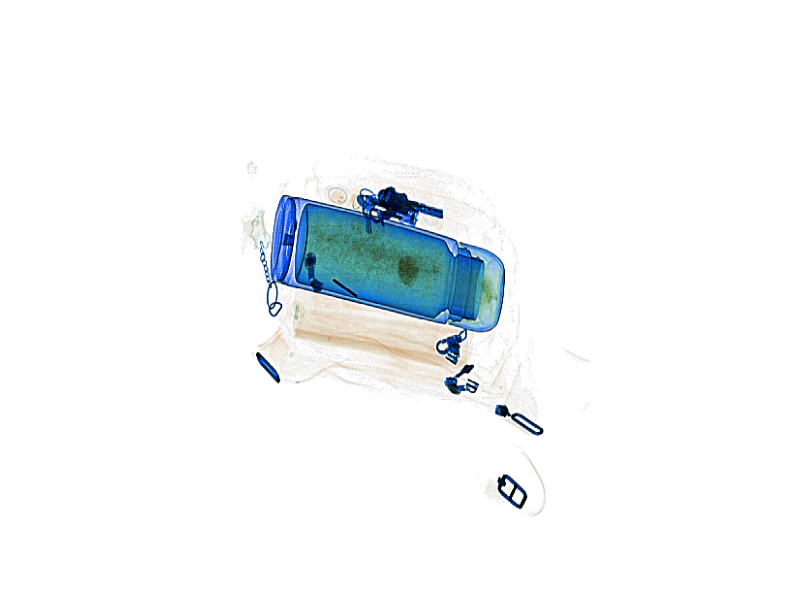

In [61]:
negative_img_path = neg_images[14]

img_neg, pred_neg = run_inference(negative_img_path, model)

print("Scores for NEGATIVE image:", pred_neg['scores'][:10])
visualize(img_neg, pred_neg, threshold=0.5)

Scores for POSITIVE image: tensor([1.0000], device='cuda:0')


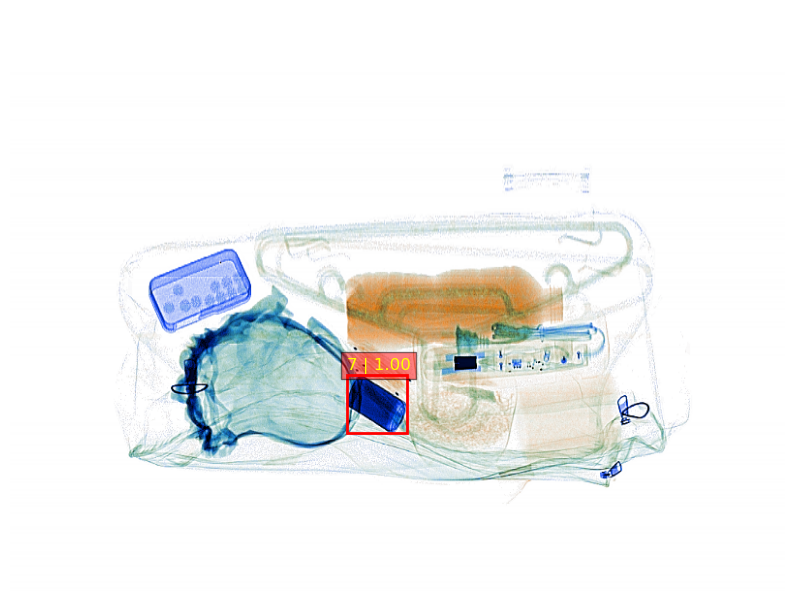

In [56]:
positive_img_path = pos_images[94]

img_pos, pred_pos = run_inference(positive_img_path, model)

print("Scores for POSITIVE image:", pred_pos['scores'][:10])
visualize(img_pos, pred_pos, threshold=0.5)

### Evaluation

In [64]:
import numpy as np

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - inter

    if union == 0:
        return 0.0

    return inter / union

In [70]:
import json

ann_file = "data/processed/coco/annotations/instances_val.json"

with open(ann_file, "r") as f:
    coco_data = json.load(f)

img_dir = "data/processed/coco/val"


In [71]:
import os

images = coco_data["images"]

image_paths = {
    img["id"]: os.path.join(img_dir, img["file_name"])
    for img in images
}

In [72]:
missing = [path for path in image_paths.values() if not os.path.exists(path)]

print("Missing image files:", len(missing))
missing[:10]


Missing image files: 0


[]

In [73]:
from tqdm import tqdm

preds = {}

for img_info in tqdm(images):
    img_id = img_info["id"]
    img_path = image_paths[img_id]

    img, pred = run_inference(img_path, model)

    preds[img_id] = {
        "boxes": pred["boxes"].cpu().numpy(),
        "scores": pred["scores"].cpu().numpy(),
        "labels": pred["labels"].cpu().numpy()
    }


100%|██████████████████████████████████████████████████████████████████████████████| 6400/6400 [07:22<00:00, 14.45it/s]


In [74]:
def compute_ap(gt, pred, iou_threshold=0.5):
    pred_boxes = pred["boxes"]
    pred_scores = pred["scores"]

    # Sort predictions by score
    order = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[order]

    tp, fp = [], []
    matched = set()

    for pb in pred_boxes:
        max_iou = 0
        max_j = -1

        for j, gb in enumerate(gt):
            iou = compute_iou(pb, gb)
            if iou > max_iou:
                max_iou = iou
                max_j = j

        if max_iou >= iou_threshold and max_j not in matched:
            tp.append(1)
            fp.append(0)
            matched.add(max_j)
        else:
            tp.append(0)
            fp.append(1)

    tp = np.array(tp)
    fp = np.array(fp)

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    precisions = cum_tp / (cum_tp + cum_fp + 1e-6)
    recalls = cum_tp / (len(gt) + 1e-6)

    ap = np.trapz(precisions, recalls)
    return ap


In [75]:
aps_50 = []
aps_75 = []
aps_coco = []

for img_id in preds:
    gt = gt_boxes.get(img_id, [])
    pred = preds[img_id]

    # Skip if both GT and predictions are empty
    if len(gt) == 0 and len(pred["boxes"]) == 0:
        continue

    # AP@50
    aps_50.append(compute_ap(gt, pred, iou_threshold=0.5))

    # AP@75
    aps_75.append(compute_ap(gt, pred, iou_threshold=0.75))

    # COCO mAP averaged over 10 IoU thresholds
    ious = np.linspace(0.5, 0.95, 10)
    aps = [compute_ap(gt, pred, iou_threshold=t) for t in ious]
    aps_coco.append(np.mean(aps))


In [76]:
print("------------------------------------------------")
print("mAP@0.50 (VOC metric):", np.mean(aps_50))
print("mAP@0.75:", np.mean(aps_75))
print("mAP@0.50:0.95 (COCO metric):", np.mean(aps_coco))
print("------------------------------------------------")

------------------------------------------------
mAP@0.50 (VOC metric): 0.02871452267010198
mAP@0.75: 0.024774972351950628
mAP@0.50:0.95 (COCO metric): 0.021558883220204075
------------------------------------------------


#### IoU Evaluation Metric

In [77]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - inter

    if union == 0:
        return 0.0

    return inter / union


In [78]:
ious = []   # store IoU for every GT object

for img_id in preds:
    gt = gt_boxes.get(img_id, [])
    pred = preds[img_id]["boxes"]

    if len(gt) == 0:
        continue  # skip negative images

    for gt_box in gt:
        best_iou = 0
        for pred_box in pred:
            best_iou = max(best_iou, compute_iou(gt_box, pred_box))

        ious.append(best_iou)


In [79]:
ious = np.array(ious)

mean_iou = np.mean(ious)
median_iou = np.median(ious)
above_0_5 = np.mean(ious >= 0.5)
above_0_3 = np.mean(ious >= 0.3)

print("--------------------------------------------------")
print("Mean IoU:", mean_iou)
print("Median IoU:", median_iou)
print("Percentage IoU ≥ 0.50:", above_0_5)
print("Percentage IoU ≥ 0.30:", above_0_3)
print("--------------------------------------------------")


--------------------------------------------------
Mean IoU: 0.7552747794759018
Median IoU: 0.8918069590294722
Percentage IoU ≥ 0.50: 0.8516306844281121
Percentage IoU ≥ 0.30: 0.866789159393661
--------------------------------------------------


### Run Model On Validation Set

In [80]:
import json

ann_path = "data/processed/coco/annotations/instances_val.json"
with open(ann_path, "r") as f:
    coco_val = json.load(f)


In [81]:
# Build GT dictionary
gt = {}

for ann in coco_val["annotations"]:
    img_id = ann["image_id"]
    x, y, w, h = ann["bbox"]
    box = [x, y, x+w, y+h]

    if img_id not in gt:
        gt[img_id] = {"boxes": [], "labels": []}

    gt[img_id]["boxes"].append(box)
    gt[img_id]["labels"].append(ann["category_id"])


In [82]:
import numpy as np

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter
    return inter / union if union != 0 else 0


In [83]:
ious = []

for img_id in preds.keys():
    pred_boxes = preds[img_id]["boxes"]
    gt_boxes = np.array(gt.get(img_id, {"boxes": []})["boxes"])

    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        continue

    for pb in pred_boxes:
        # compute best IoU with any GT box
        iou_val = max([compute_iou(pb, gb) for gb in gt_boxes])
        ious.append(iou_val)


In [84]:
ious = np.array(ious)

print("Mean IoU:", np.mean(ious))
print("Median IoU:", np.median(ious))
print("IoU ≥ 0.5:", np.mean(ious >= 0.5))
print("IoU ≥ 0.3:", np.mean(ious >= 0.3))


Mean IoU: 0.7597261389986929
Median IoU: 0.8842617461532668
IoU ≥ 0.5: 0.855078125
IoU ≥ 0.3: 0.892578125
